In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn

from sklearn.metrics import mean_absolute_error 
import seaborn as sb
import warnings 

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

matplotlib.style.use('ggplot')

np.random.seed(42)

In [3]:
try:
    import shap
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet https://github.com/ceshine/shap/archive/master.zip
    import shap

     | 58.0 MB 9.1 MB/s 0:00:05
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.3 MB/s eta 0:00:00


In [4]:
train_df = pd.read_csv("drive/MyDrive/ST4248/data/resale_train_feature_selection.csv")
test_df = pd.read_csv("drive/MyDrive/ST4248/data/resale_test_feature_selection.csv")

# Price

## Data Check

In [109]:
X_train = train_df.drop("resale_price", axis = 1)
X_test = test_df.drop("resale_price", axis = 1)

y_train = train_df["resale_price"]
y_test = test_df["resale_price"]

In [110]:
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [111]:
X_train

tensor([[-1.1324, -0.6765, -0.4436,  ..., -0.0477, -0.1484, -0.0755],
        [-2.0103,  0.2013,  1.2523,  ..., -0.0477, -0.1484, -0.0755],
        [ 1.1667, -0.3844, -0.1985,  ..., -0.0477, -0.1484, -0.0755],
        ...,
        [-0.1292, -1.3211, -1.1494,  ..., -0.0477, -0.1484, -0.0755],
        [-2.0103,  1.5669,  0.4485,  ..., -0.0477, -0.1484, -0.0755],
        [-1.1743, -0.2372, -0.1103,  ..., -0.0477, -0.1484, -0.0755]])

In [112]:
X_test

tensor([[-0.2128,  0.0047,  1.2915,  ..., -0.0477, -0.1484, -0.0755],
        [-0.0874,  1.3063,  0.2426,  ..., -0.0477, -0.1484, -0.0755],
        [ 0.0380, -0.3413,  0.6445,  ..., -0.0477, -0.1484, -0.0755],
        ...,
        [-1.5087,  1.5941,  0.0367,  ..., -0.0477, -0.1484, -0.0755],
        [ 1.1249, -0.1131,  1.4974,  ..., -0.0477, -0.1484, -0.0755],
        [-0.0874, -0.2632, -0.4828,  ..., -0.0477, -0.1484, -0.0755]])

In [113]:
y_train

tensor([388000., 315000., 588000.,  ..., 530000., 330000., 355000.])

In [114]:
y_test

tensor([ 550000.,  570000.,  518000.,  795000.,  410000.,  588000.,  410000.,
         506000., 1068000.,  400000.,  650000.,  805888.,  340000.,  765000.,
         470000.,  530000.,  525000.,  270000., 1068000.,  585000.,  583000.,
         730000.,  740000.,  480000.,  868000.,  310000.,  780000.,  980000.,
         710000.,  560000.,  578000.,  610000.,  470000.,  675000.,  320000.,
         528000.,  568000.,  690000.,  470000.,  762000.,  345000.,  340000.,
        1125000.,  585000.,  458000.,  503888.,  568000.,  582000.,  640000.,
         828888.,  375000.,  565000.,  790000.,  448000.,  480000.,  615000.,
         350000.,  515500.,  430000.,  442000.,  360000.,  460000.,  400000.,
         695000.,  860000.,  525000.,  568888.,  515000.,  760000.,  650000.,
         385000.,  635000.,  945000.,  525000.,  639000.,  615000.,  380000.,
         495000.,  492000.,  428000.,  500000.,  585000.,  420000.,  368888.,
         613888.,  528000.,  620000.,  575000.,  455000.,  75200

## Make the Deep Neural Network
 


In [162]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(X_train.shape[1], 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
        )

    def forward(self, x):
        # x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [163]:
NN_model = NeuralNetwork()
print(NN_model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=74, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [164]:
learning_rate = 0.1
l = nn.MSELoss()
optimizer = torch.optim.Adam(NN_model.parameters(), lr = learning_rate)

## Train the model :

In [165]:
num_epochs = 500
for epoch in range(num_epochs):
    #forward feed
    y_pred = NN_model(X_train)
    #calculate the loss
    loss= l(y_pred.flatten(), y_train)

    #backward propagation: calculate gradients
    loss.backward()

    #update the weights
    optimizer.step()

    #clear out the gradients from the last step loss.backward()
    optimizer.zero_grad()
    
    print('epoch {}, loss {}'.format(epoch, loss.item()))

epoch 0, loss 339000492032.0
epoch 1, loss 325092835328.0
epoch 2, loss 157769859072.0
epoch 3, loss 583306444800.0
epoch 4, loss 53803388928.0
epoch 5, loss 194669953024.0
epoch 6, loss 266573774848.0
epoch 7, loss 298449895424.0
epoch 8, loss 314072104960.0
epoch 9, loss 322224062464.0
epoch 10, loss 326180601856.0
epoch 11, loss 327529988096.0
epoch 12, loss 327139655680.0
epoch 13, loss 325052366848.0
epoch 14, loss 320650838016.0
epoch 15, loss 312401723392.0
epoch 16, loss 296991227904.0
epoch 17, loss 268384157696.0
epoch 18, loss 217412468736.0
epoch 19, loss 151979458560.0
epoch 20, loss 203404836864.0
epoch 21, loss 183792893952.0
epoch 22, loss 123493416960.0
epoch 23, loss 136263802880.0
epoch 24, loss 145313464320.0
epoch 25, loss 124002770944.0
epoch 26, loss 83257810944.0
epoch 27, loss 88910577664.0
epoch 28, loss 83340869632.0
epoch 29, loss 46952742912.0
epoch 30, loss 47498633216.0
epoch 31, loss 42015518720.0
epoch 32, loss 26291591168.0
epoch 33, loss 37239566336.0

## Test the model

In [166]:
y_train_pred = NN_model(X_train.to(torch.float32)).detach().numpy().flatten()
y_test_pred = NN_model(X_test.to(torch.float32)).detach().numpy().flatten()

In [167]:
y_train_pred

array([391627.34, 300502.94, 542992.75, ..., 525864.8 , 324914.16,
       367788.62], dtype=float32)

In [168]:
train_n = X_train.shape[0]
train_p = X_train.shape[1]
train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
train_rmse = mean_squared_error(y_train, y_train_pred, squared = False)
train_r2 = r2_score(y_train, y_train_pred)
train_adj_r2 = 1 - (1 - train_r2) * (train_n - 1) / (train_n - train_p - 1)

In [169]:
test_n = X_test.shape[0]
test_p = X_test.shape[1]
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
test_rmse = mean_squared_error(y_test, y_test_pred, squared = False)
test_r2 = r2_score(y_test, y_test_pred)
test_adj_r2 = 1 - (1 - test_r2) * (test_n - 1) / (test_n - test_p - 1)

In [170]:
print("Train MAPE: {:.2f}%".format(train_mape * 100))
print("Train RMSE:", train_rmse)
print("Train R2:", train_r2)
print("Train Adj R2:", train_adj_r2)
print()
print("Test MAPE: {:.2f}%".format(test_mape * 100))
print("Test RMSE:", test_rmse)
print("Test R2:", test_r2)
print("Test Adj R2:", test_adj_r2)

Train MAPE: 3.73%
Train RMSE: 28045.781
Train R2: 0.9726039760754253
Train Adj R2: 0.9720168617486316

Test MAPE: 5.26%
Test RMSE: 43278.21
Test R2: 0.9313916250441715
Test Adj R2: 0.925100398592212


In [171]:
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

## Plot

Text(0.5, 1.0, 'Residual Plot')

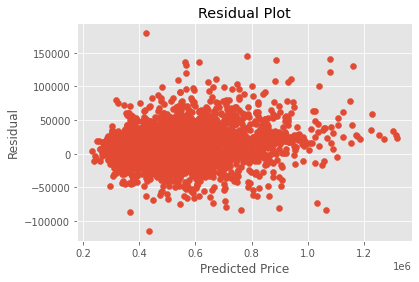

In [172]:
#idk residual plot is vs predicted value or actual value lol
plt.scatter(y_train_pred, train_residuals)
plt.xlabel("Predicted Price")
plt.ylabel("Residual")
plt.title("Residual Plot")

Text(0.5, 1.0, 'Residual Plot')

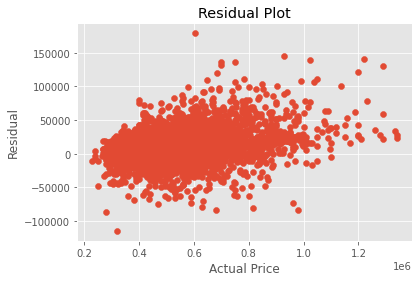

In [173]:
plt.scatter(y_train, train_residuals)
plt.xlabel("Actual Price")
plt.ylabel("Residual")
plt.title("Residual Plot")

Text(0.5, 1.0, 'Actual vs Predicted Price')

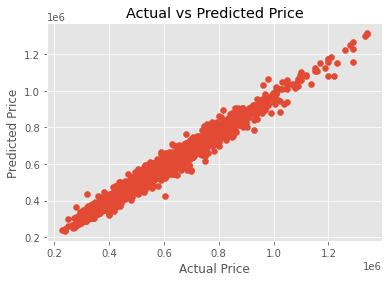

In [174]:
plt.scatter(y_train, y_train_pred)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Price")

In [180]:
%%time
e = shap.DeepExplainer(NN_model, X_train)

CPU times: user 39.6 ms, sys: 101 µs, total: 39.7 ms
Wall time: 107 ms


In [181]:
%%time
shap_values = e.shap_values(X_test)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


AttributeError: ignored

In [178]:
shap_values.shape

NameError: ignored

In [ ]:
df = pd.DataFrame({
    "mean_abs_shap": np.mean(np.abs(shap_values), axis=0), 
    "stdev_abs_shap": np.std(np.abs(shap_values), axis=0), 
    "name": features
})
df.sort_values("mean_abs_shap", ascending=False)[:10]

In [ ]:
shap.summary_plot(shap_values, features=x_samples, feature_names=features)

# Price / Sqm

## Data Check

In [ ]:
train_df2 = train_df.copy()
test_df2 = test_df.copy()

train_df2["floor_area_sqm"] = train_df2["floor_area_sqm"].apply(lambda x : x * 23.922319549360488 + 95.09078798185942)
test_df2["floor_area_sqm"] = test_df2["floor_area_sqm"].apply(lambda x : x * 23.922319549360488 + 95.09078798185942)

train_df2["resale_price_per_sqm"] = train_df2["resale_price"] / train_df2["floor_area_sqm"]
test_df2["resale_price_per_sqm"] = test_df2["resale_price"] / test_df2["floor_area_sqm"]

In [ ]:
X_train = train_df2.drop(["resale_price_per_sqm", "resale_price", "floor_area_sqm"], axis = 1)
X_test = test_df2.drop(["resale_price_per_sqm", "resale_price", "floor_area_sqm"], axis = 1)

y_train = train_df2["resale_price_per_sqm"]
y_test = test_df2["resale_price_per_sqm"]

In [ ]:
X_train.head()

In [ ]:
X_test.head()

## Make the Deep Neural Network
 * Define a sequential model
 * Add some dense layers
 * Use '**relu**' as the activation function in the hidden layers
 * Use a '**normal**' initializer as the kernal_intializer 
           Initializers define the way to set the initial random weights of Keras layers.
 * We will use mean_absolute_error as a loss function
 * Define the output layer with only one node
 * Use 'linear 'as the activation function for the output layer
 


In [ ]:
NN_model = Sequential()

**The Input Layer**

In [ ]:
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

**The Hidden Layers**

In [ ]:
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

**The Output Layer**

In [ ]:
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

**Compile the network**

In [ ]:
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

**Define a checkpoint callback :**

In [ ]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

## Train the model :

In [ ]:
NN_model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

## Test the model

In [ ]:
y_train_pred = NN_model.predict(X_train)
y_test_pred = NN_model.predict(X_test)

In [ ]:
y_train_pred = y_train_pred.flatten()
y_test_pred = y_test_pred.flatten()

In [ ]:
y_train = y_train * train_df2["floor_area_sqm"]
y_train_pred = y_train_pred * train_df2["floor_area_sqm"]

In [ ]:
y_test = y_test * test_df2["floor_area_sqm"]
y_test_pred = y_test_pred * test_df2["floor_area_sqm"]

In [ ]:
train_n = X_train.shape[0]
train_p = X_train.shape[1]
train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
train_rmse = mean_squared_error(y_train, y_train_pred, squared = False)
train_r2 = r2_score(y_train, y_train_pred)
train_adj_r2 = 1 - (1 - train_r2) * (train_n - 1) / (train_n - train_p - 1)

In [ ]:
test_n = X_test.shape[0]
test_p = X_test.shape[1]
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
test_rmse = mean_squared_error(y_test, y_test_pred, squared = False)
test_r2 = r2_score(y_test, y_test_pred)
test_adj_r2 = 1 - (1 - test_r2) * (test_n - 1) / (test_n - test_p - 1)

In [ ]:
print("Train MAPE: {:.2f}%".format(train_mape * 100))
print("Train RMSE:", train_rmse)
print("Train R2:", train_r2)
print("Train Adj R2:", train_adj_r2)
print()
print("Test MAPE: {:.2f}%".format(test_mape * 100))
print("Test RMSE:", test_rmse)
print("Test R2:", test_r2)
print("Test Adj R2:", test_adj_r2)

In [ ]:
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

## Plot

In [ ]:
#idk residual plot is vs predicted value or actual value lol
plt.scatter(y_train_pred, train_residuals)
plt.xlabel("Predicted Price")
plt.ylabel("Residual")
plt.title("Residual Plot")

In [ ]:
plt.scatter(y_train, train_residuals)
plt.xlabel("Actual Price")
plt.ylabel("Residual")
plt.title("Residual Plot")

In [ ]:
plt.scatter(y_train, y_train_pred)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Price")